# nb-model_xg-model-neural-process-clf-ddir

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath, exists
from pathlib import Path
from functools import partial
import random
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'nb-model_xg-model-neural-process-clf-ddir.ipynb'
dir_name = 'model'
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
from verification.batch_norm import BatchNormVerificationCallback
from verification.batch_gradient import BatchGradientVerificationCallback

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

from common_util import MODEL_DIR, load_json, dump_json, rectify_json, load_df, str_now, makedir_if_not_exists, is_valid, isnt, compose, pd_split_ternary_to_binary, df_del_midx_level, midx_intersect, pd_get_midx_level, pd_rows, df_midx_restack
from model.common import ASSETS, DATASET_DIR, XG_PROCESS_DIR, XG_DATA_DIR, XG_DIR, PYTORCH_MODELS_DIR, TRAIN_RATIO, EXPECTED_NUM_HOURS
from model.pl_xgdm import XGDataModule
from model.pl_np import NPModel
from model.np_util2 import AttentiveNP
from recon.viz import *
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

CRITICAL:root:script location: /home/kev/crunch/model/nb-model_xg-model-neural-process-clf-ddir.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/


Prune the xg data down to the data of interest to use in further experiments.

In [2]:
%autoreload 1
%aimport model.np_util2, model.train_util, model.pl_np, model.pl_generic, model.metrics_util, model.model_util, model.pl_xgdm

In [3]:
# s=0
# torch.manual_seed(s)
# random.seed(s)
# np.random.seed(s)

In [4]:
torch.seed()

449586937993264785

In [5]:
model_name = 'anp'
asset_name = ASSETS[0]
# hpomzug
dsubs = 'h' # h z
fdata_name = f'h_pba_{dsubs}'
# fdata_name = f'h_vol_{dsubs}'
# fdata_name = f'h_pba_{dsubs},h_vol_{dsubs}'
ldata_name = 'ddir' 
loss_type = 'clf-ce'
model_type = loss_type.split('-')[0]
monitor = 'val_f1.0' if (model_type == 'clf') else 'val_mae'
num_classes = 2 if (model_type == 'clf') else None

optimize_dir = {
    'val_loss': 'minimize',
    'val_mae': 'minimize',
    'val_mse': 'minimize'
}.get(monitor, 'maximize')

pl_model_fn, pt_model_fn = NPModel, AttentiveNP
model_name = f'{model_type}_{pl_model_fn.__name__}_{pt_model_fn.__name__}'
logging.getLogger("lightning").setLevel(logging.ERROR)
print('cuda status: {}'.format('✓' if (torch.cuda.is_available()) else '🞩'))

cuda status: ✓


In [6]:
t_params = pl_model_fn.suggest_params(loss_type=loss_type)

fret=None
dm = XGDataModule(t_params, asset_name, fdata_name, ldata_name, interval=(1996, 2018), fret=fret,
                  overwrite_cache=False)
dm.prepare_data()
dm.setup()

m_params = pt_model_fn.suggest_params(num_classes=num_classes, num_channels=dm.fobs[0],
                                      loss_type=loss_type)

In [7]:
m_params

{'in_name': 'bn2d',
 'in_params': {'momentum': 0.1, 'affine': False, 'track_running_stats': False},
 'ft_name': 'stcn',
 'ft_params': {'size': 10,
  'depth': 2,
  'kernel_sizes': 8,
  'input_dropout': 0.1,
  'global_dropout': 0.3,
  'output_dropout': 0.3,
  'dropout_type': '2d',
  'dilation_factor': 4,
  'global_dilation': True,
  'block_act': 'relu',
  'out_act': 'relu',
  'block_init': 'kaiming_uniform',
  'out_init': 'kaiming_uniform',
  'pad_mode': 'full'},
 'det_encoder_params': {'class_agg': False,
  'xa_name': 'mha',
  'xa_params': {'num_heads': 10, 'dropout': 0.3, 'depth': 1},
  'rt_name': 'mha',
  'rt_params': {'num_heads': 10, 'dropout': 0.3, 'depth': 1}},
 'lat_encoder_params': {'latent_size': None,
  'cat_before_rt': True,
  'class_agg': True,
  'rt_name': 'mha',
  'rt_params': {'num_heads': 10, 'dropout': 0.3, 'depth': 1},
  'dist_type': 'normal',
  'min_std': 0.01,
  'use_lvar': False},
 'decoder_params': {'de_name': 'ffn',
  'de_params': {'out_shapes': [256, 16],
   'fla

In [8]:
# tcn_sizes = [(31, 11), (6, 26), (5, 19), (27, 15)]
# tcn_depth = [(4, 2), (5, 3), (4, 4), (4, 3)]
# tcn_kernel_sizes = [(15, 47), (7, 39), (17, 47), (15, 15)]
# tcn_input_dropout = [(.01, .10), (0, 0), (.21, .63), (.77, .33)]
# tcn_output_dropout = [(.02, .45), (.15, .74), (.82, .69), (.64, .18)]
# tcn_global_dropout = [(.04, .35), (.08, .23), (.46, .47), (.13, 0)]

In [9]:
dm.fobs

(1, 5, 160)

In [10]:
mdl = pl_model_fn(pt_model_fn, m_params, t_params, dm.fobs)

In [11]:
mdl

NPModel(
  (loss): CrossEntropyLoss()
  (model): AttentiveNP(
    (input_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (feat_transform): StackedTCN(
      (model): Sequential(
        (rb[conv2d]_0): ResidualBlock(
          (net): Sequential(
            (tl[(1, 5, 160)->(10, 1, 167)]_0_0): TemporalLayer2d(
              (layer): Sequential(
                (0): ReplicationPad2d((7, 7, 0, 0))
                (1): Conv2d(1, 10, kernel_size=(5, 8), stride=(1, 1))
                (2): ReLU()
                (3): Dropout2d(p=0.1, inplace=False)
              )
            )
            (tl[(10, 1, 167)->(10, 1, 195)]_0_1): TemporalLayer2d(
              (layer): Sequential(
                (0): ReplicationPad2d((28, 28, 0, 0))
                (1): Conv2d(10, 10, kernel_size=(1, 8), stride=(1, 1), dilation=(1, 4))
                (2): ReLU()
                (3): Dropout2d(p=0.3, inplace=False)
              )
            )
          )
         

In [12]:
l, t = dm.train[1], dm.train[2]
if (l.shape[-1] == 2):
    l_new = np.sum(l, axis=(1, 2), keepdims=False)		# Sum label matrices to scalar values
    if (l.shape[1] > 1):
        l_new += l.shape[1]
    l = l_new
else:
    raise NotImplementedError("code to process label with given shape not written")

if (t.shape[-1] == 2):
    if (len(t[(t == 0.).all(axis=-1)]) != 0):
        t[(t==0.).all(axis=-1)] = np.array([-1e-6, 0])
    t_new = t[t!=0.0]
    assert len(t_new)==len(t), "target with zeros removed not equal to original"
    t = t_new
else:
    raise NotImplementedError("code to process target with given shape not written")

freq_count = np.unique(l_new, return_counts=True)[1] / len(l_new)
print(freq_count)

[0.47151205 0.52848795]


In [13]:
l, t = dm.val[1], dm.val[2]
if (l.shape[-1] == 2):
    l_new = np.sum(l, axis=(1, 2), keepdims=False)		# Sum label matrices to scalar values
    if (l.shape[1] > 1):
        l_new += l.shape[1]
    l = l_new
else:
    raise NotImplementedError("code to process label with given shape not written")

if (t.shape[-1] == 2):
    t_new = t[t!=0.0]
    assert len(t_new)==len(t), "target with zeros removed not equal to original"
    t = t_new
else:
    raise NotImplementedError("code to process target with given shape not written")

freq_count = np.unique(l_new, return_counts=True)[1] / len(l_new)
print(freq_count)

[0.45799854 0.54200146]


In [14]:
class GraphDumpCallback(pl.Callback):
    def __init__(self):
        super().__init__()

    def on_train_end(self, trainer, pl_module):
        pass
        print('on_train_end')
        #print(pl_module.epoch_returns['train']['br'])

    def on_fit_end(self, trainer, pl_module):
        pass
        print('on_fit_end')
        #print(pl_module.epoch_returns['train']['br'])

In [15]:
# dm.train_idx, dm.val_idx, dm.test_idx

## Neural Process

In [16]:
trial_time = str_now().replace(' ', '_').replace(':', '-')
study_dir = MODEL_DIR +sep.join(['log', model_name, asset_name, dm.name]) +sep
trial_dir = f'{study_dir}{trial_time}{sep}'
makedir_if_not_exists(trial_dir)
dump_json(rectify_json(m_params), 'params_m.json', trial_dir)
dump_json(rectify_json(t_params), 'params_t.json', trial_dir)
max_epochs = t_params['epochs']
min_epochs = max_epochs // 5

csv_log = pl.loggers.csv_logs.CSVLogger(trial_dir, name='', version='')
tb_log = pl.loggers.tensorboard.TensorBoardLogger(trial_dir, name='', \
    version='', log_graph=False)
chk_callback = pl.callbacks.ModelCheckpoint(f'{trial_dir}chk{sep}', \
    monitor=monitor, mode=optimize_dir[:3])
es_callbacks = (EarlyStopping(monitor=monitor, min_delta=0.00, patience=max_epochs//5,
                            verbose=False, mode=optimize_dir[:3]),)
# ver_callbacks = (BatchNormVerificationCallback(), \
#                 BatchGradientVerificationCallback())
ver_callbacks = ()
# es_callbacks = ()
gd_callbacks = () #(GraphDumpCallback(),)

trainer = pl.Trainer(max_epochs=max_epochs, min_epochs=min_epochs, logger=[csv_log, tb_log],
            callbacks=[chk_callback, *es_callbacks, *ver_callbacks],
            limit_val_batches=1.0, gradient_clip_val=0, gradient_clip_algorithm='norm',
            stochastic_weight_avg=False, auto_lr_find=False, #track_grad_norm=2,
            amp_level='O1', precision=mdl.get_precision(),
            default_root_dir=trial_dir, weights_summary=None,
            gpus=-1 if (torch.cuda.is_available()) else None)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [17]:
trainer.fit(mdl, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory /home/kev/crunch/model/log/clf_NPModel_AttentiveNP/sp_500/1996_2018_ddir_h_pba_h/2021-06-03_21-51-47/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Params
### TCN decoders
* increase dropout
* decrease layers

In [18]:
train_br = mdl.epoch_returns['train']['br'].compute_returns()
val_br = mdl.epoch_returns['val']['br'].compute_returns()
val_cr = mdl.epoch_returns['val']['cr'].compute_returns()
val_kr = mdl.epoch_returns['val']['kr'].compute_returns()
val_br_pred = mdl.epoch_returns['val']['br'].pred_dir

In [19]:
[len(p[p==1])/len(p) for p in val_br_pred] # make sure both directions are predicted

[0.6875,
 0.59375,
 0.65625,
 0.59375,
 0.65625,
 0.75,
 0.625,
 0.53125,
 0.875,
 0.8125,
 0.65625,
 0.71875,
 0.65625,
 0.75,
 0.625,
 0.5625,
 0.6875,
 0.59375,
 0.46875,
 0.65625,
 0.5,
 0.875,
 0.53125,
 0.8125,
 0.53125,
 0.6875,
 0.65625,
 0.75,
 0.5,
 0.71875,
 0.6875,
 0.75,
 0.625,
 0.75,
 0.46875,
 0.5,
 0.5,
 0.6875,
 0.625,
 0.59375,
 0.625]

<module 'matplotlib.pyplot' from '/home/kev/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

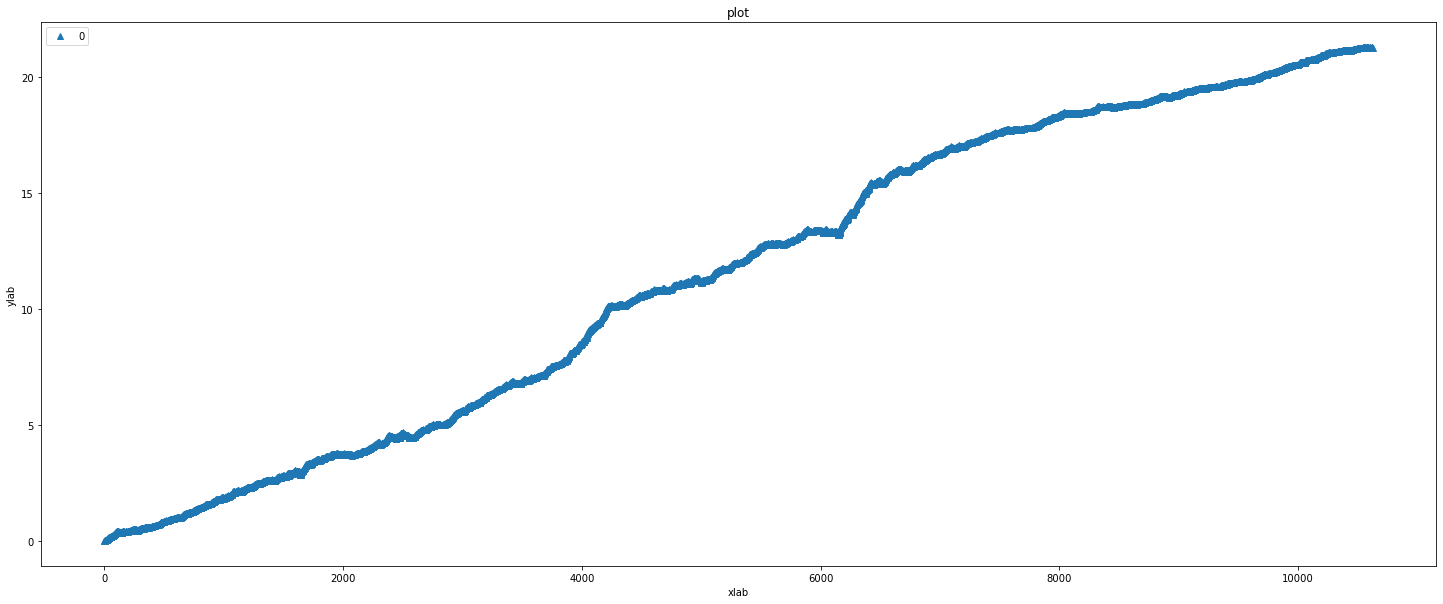

In [20]:
plot_df(pd.DataFrame(train_br.numpy()))

In [21]:
bench_fname = 'benchmark.json'
if (not exists('{study_dir}{bench_fname}')):
    bench = dm.get_benchmarks(train_len=len(train_br), val_len=len(val_br), test_len=None)
    dump_json(bench, bench_fname, study_dir)
bench_strats = dm.get_benchmark_strats(train_len=len(train_br), val_len=len(val_br), test_len=None)
# if (not exists('{study_dir}{bench_fname}')):
#     bench = dm.get_benchmarks(train_len=None, val_len=None, test_len=None)
# #     dump_json(bench, bench_fname, study_dir)
# bench_strats = dm.get_benchmark_strats(train_len=None, val_len=None, test_len=None)

<module 'matplotlib.pyplot' from '/home/kev/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

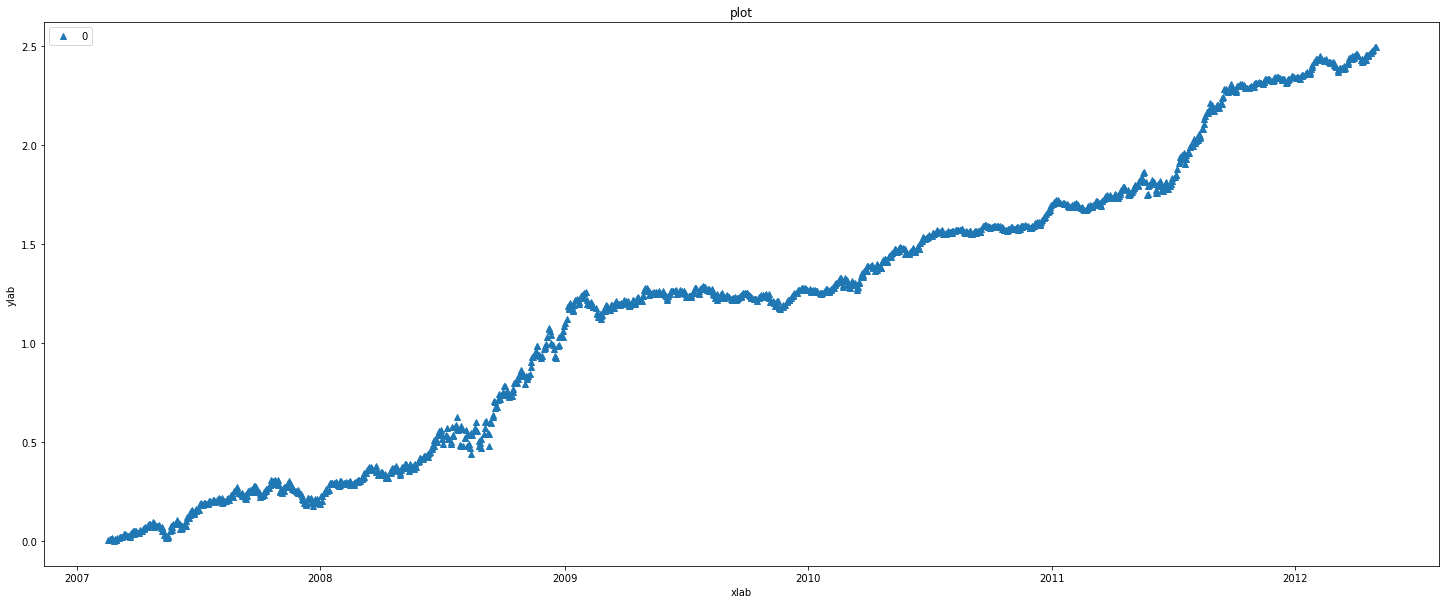

In [22]:
plot_df(pd.DataFrame(val_br.numpy(), index=bench_strats['val']['index']))

<module 'matplotlib.pyplot' from '/home/kev/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

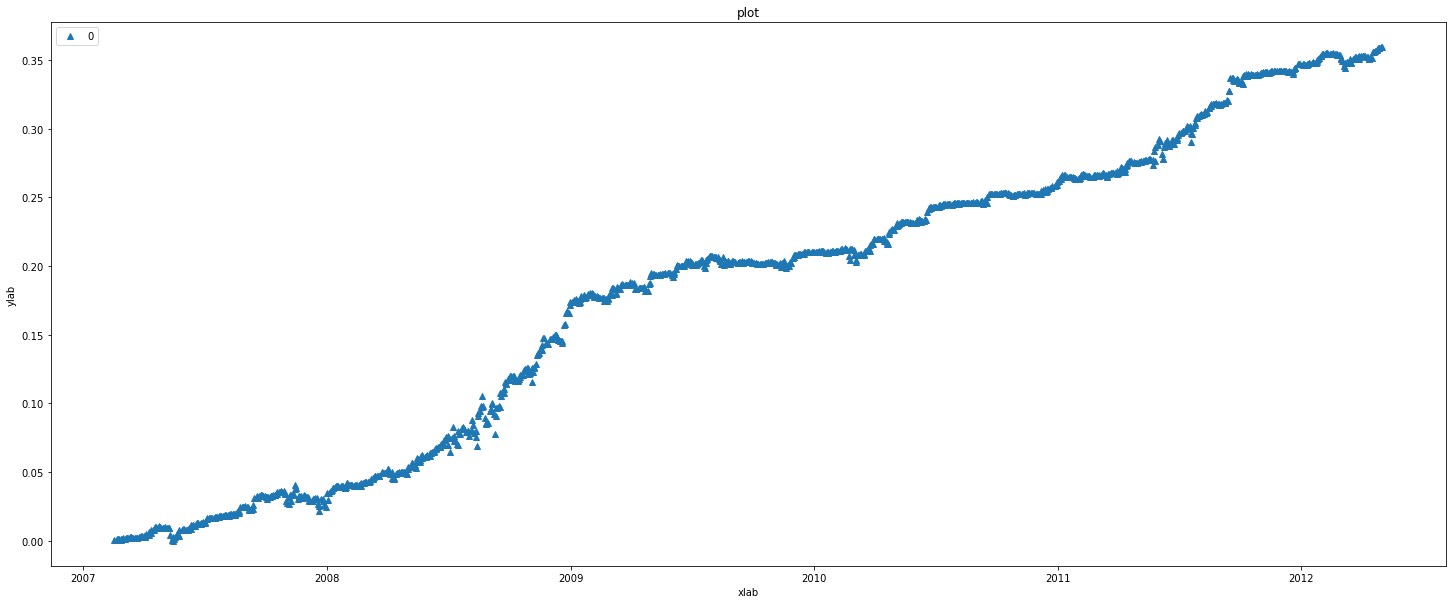

In [23]:
plot_df(pd.DataFrame(val_kr.numpy(), index=bench_strats['val']['index']))

<module 'matplotlib.pyplot' from '/home/kev/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

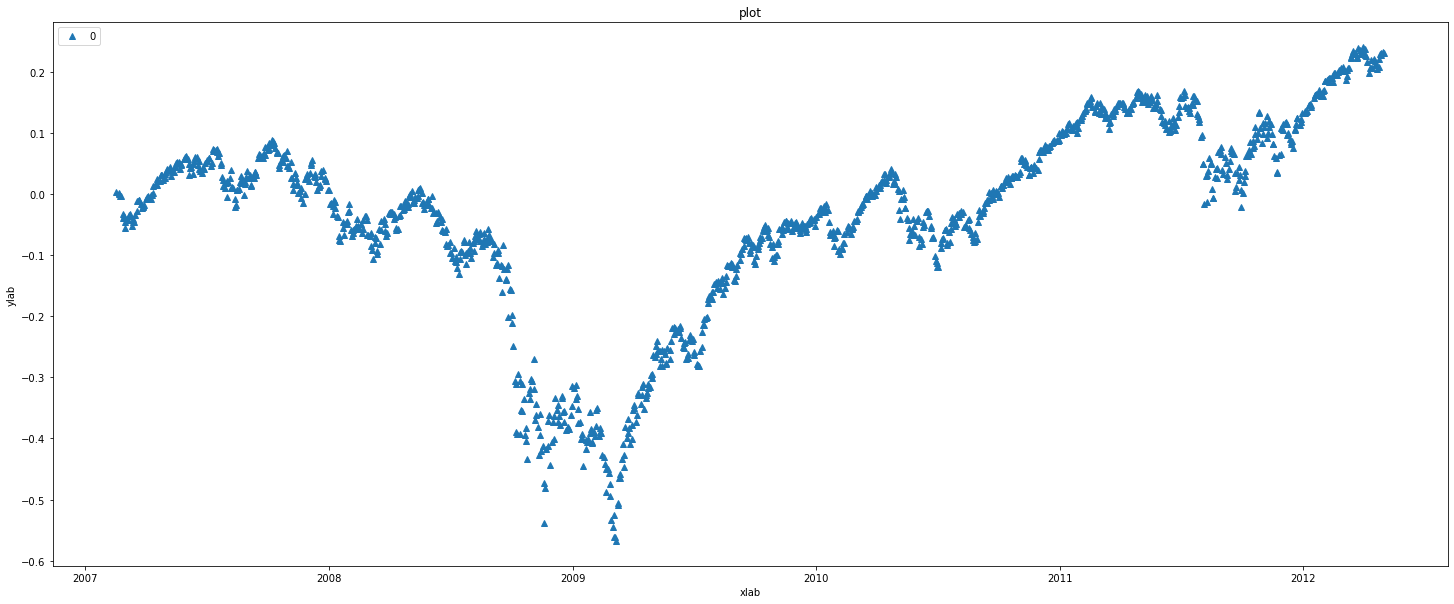

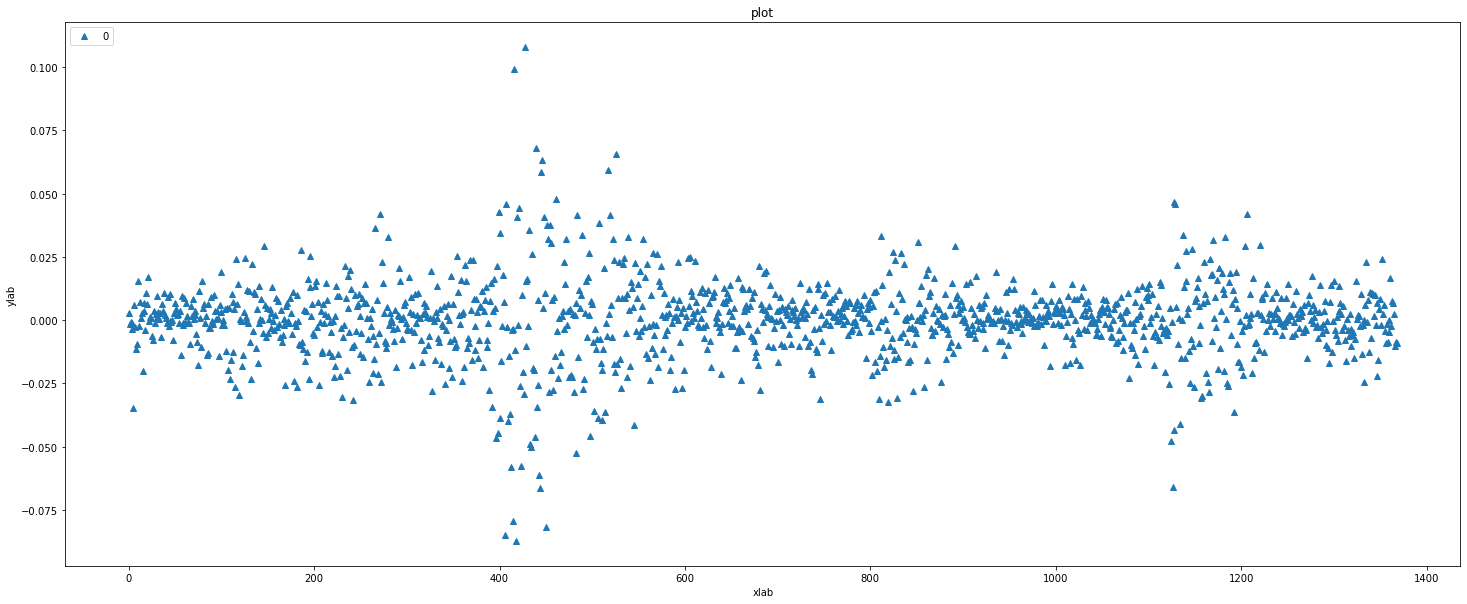

In [24]:
bs = bench_strats['val']['bs'].compute_returns()
plot_df(pd.DataFrame(bs.numpy(), index=bench_strats['val']['index']))
t = dm.val[2]
plot_df(pd.DataFrame(t[t!=0]))

<module 'matplotlib.pyplot' from '/home/kev/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

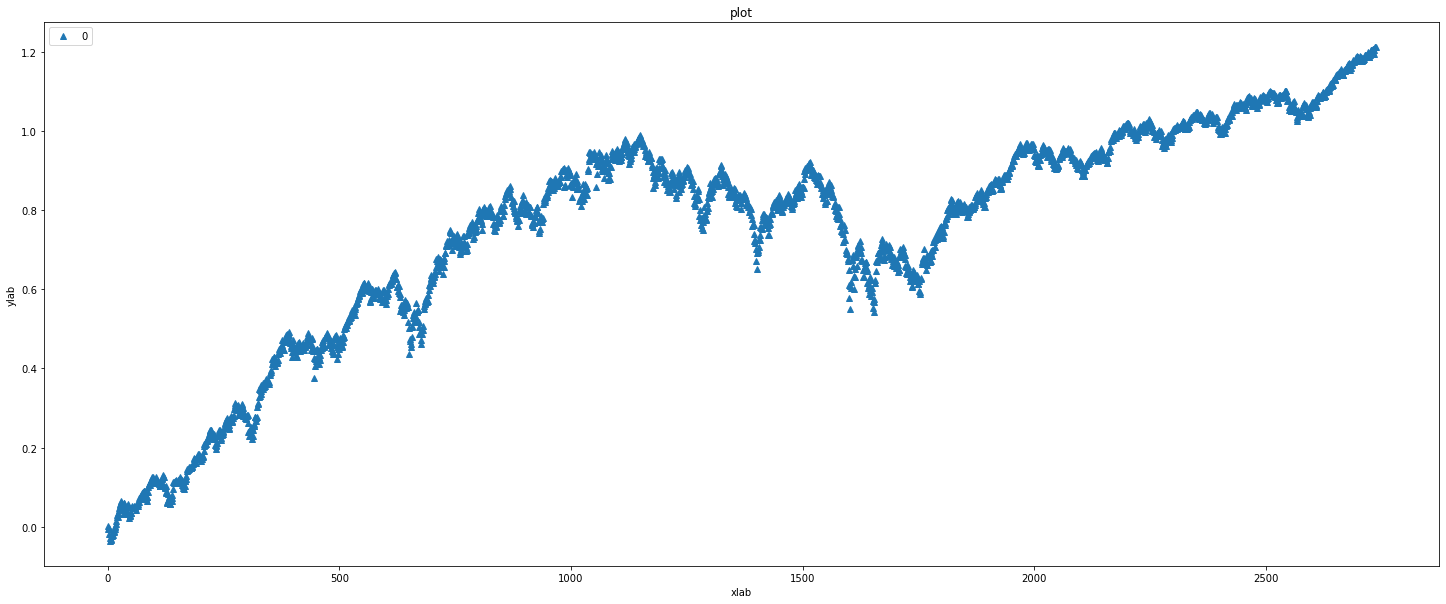

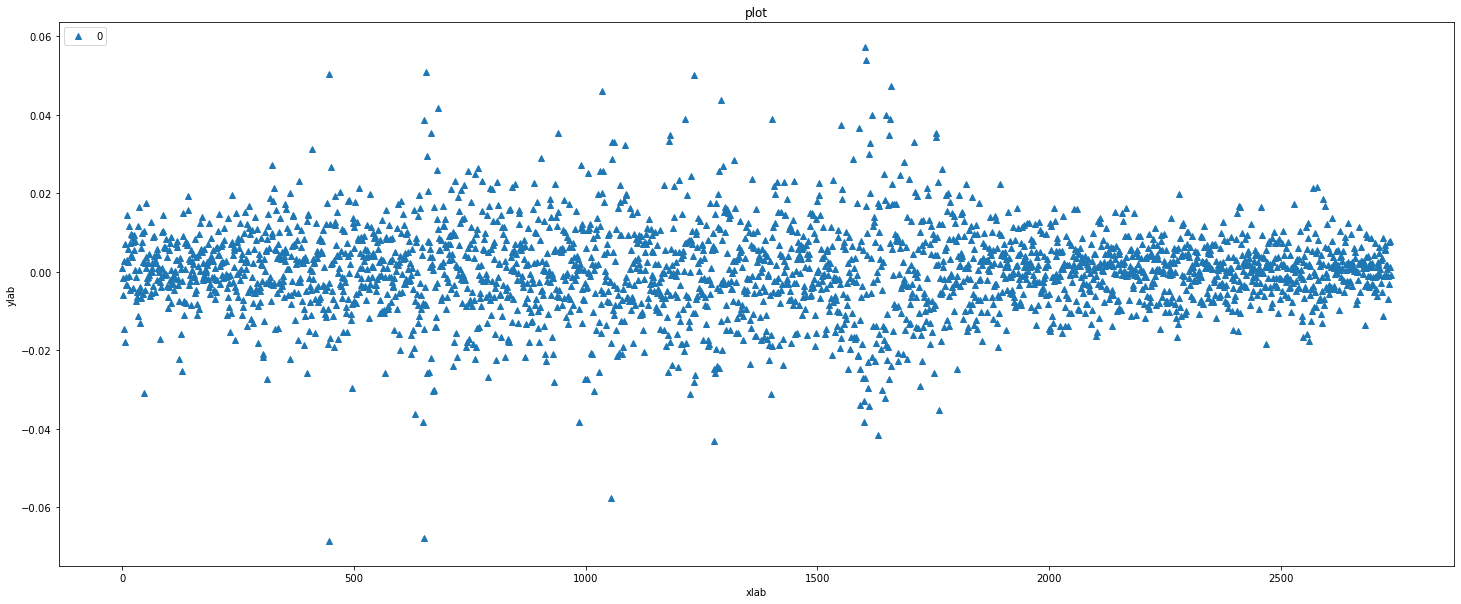

In [25]:
bs = bench_strats['train']['bs'].compute_returns()
plot_df(pd.DataFrame(bs.numpy()))
t = dm.train[2]
plot_df(pd.DataFrame(t[t!=0]))

<module 'matplotlib.pyplot' from '/home/kev/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

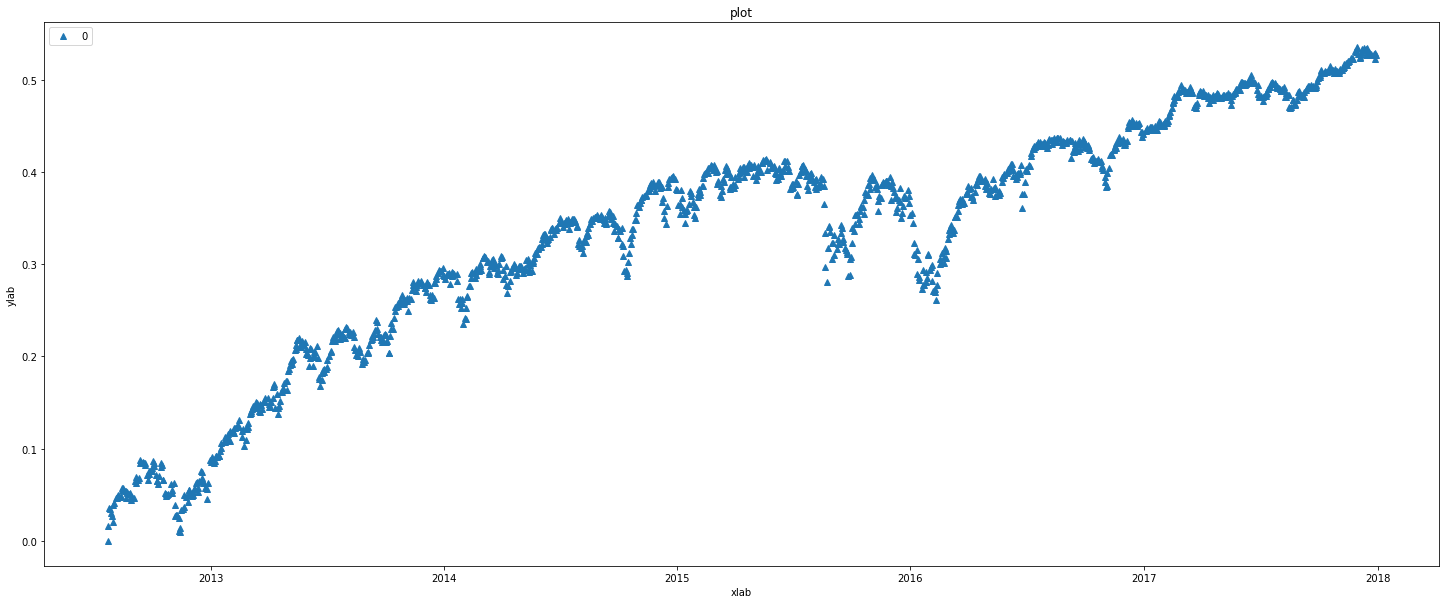

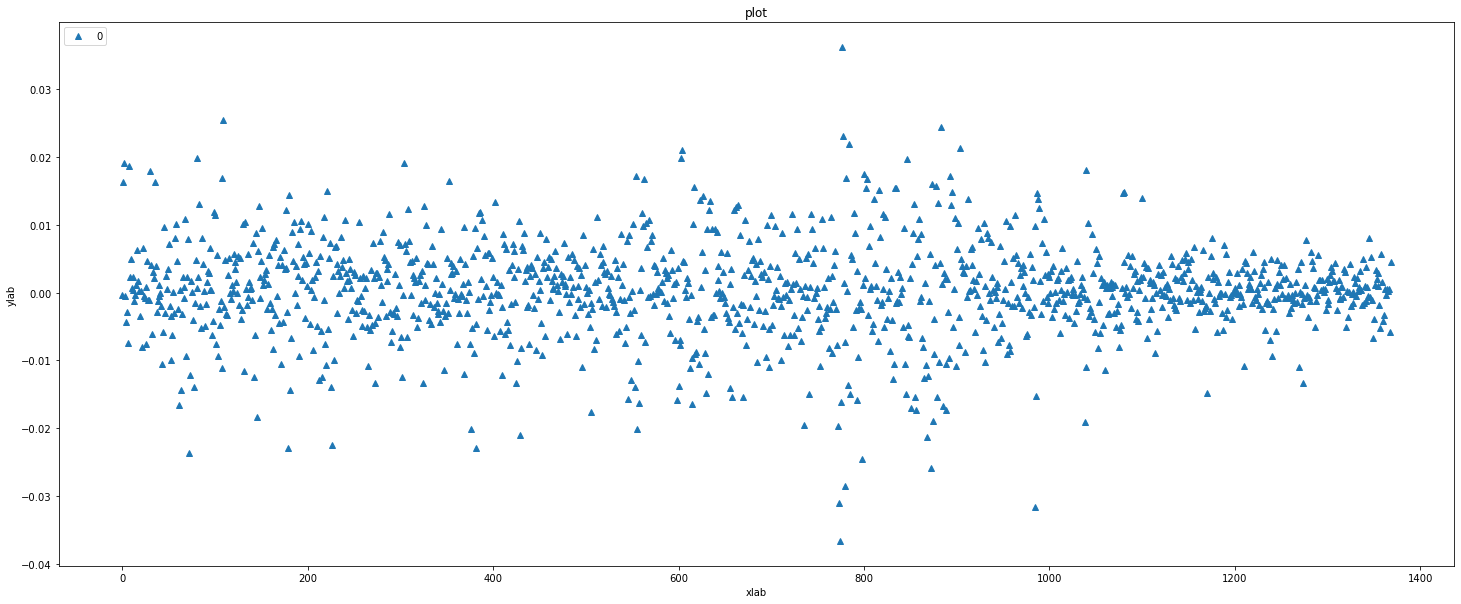

In [26]:
bs = bench_strats['test']['bs'].compute_returns()
plot_df(pd.DataFrame(bs.numpy(), index=bench_strats['test']['index']))
t = dm.test[2]
plot_df(pd.DataFrame(t[t!=0]))

In [27]:
bench_res = load_json('benchmark.json', study_dir)
raw_res = load_df('metrics.csv', trial_dir, data_format='csv')
statlen = min_epochs//5
print(f'{statlen=}')

statlen=4


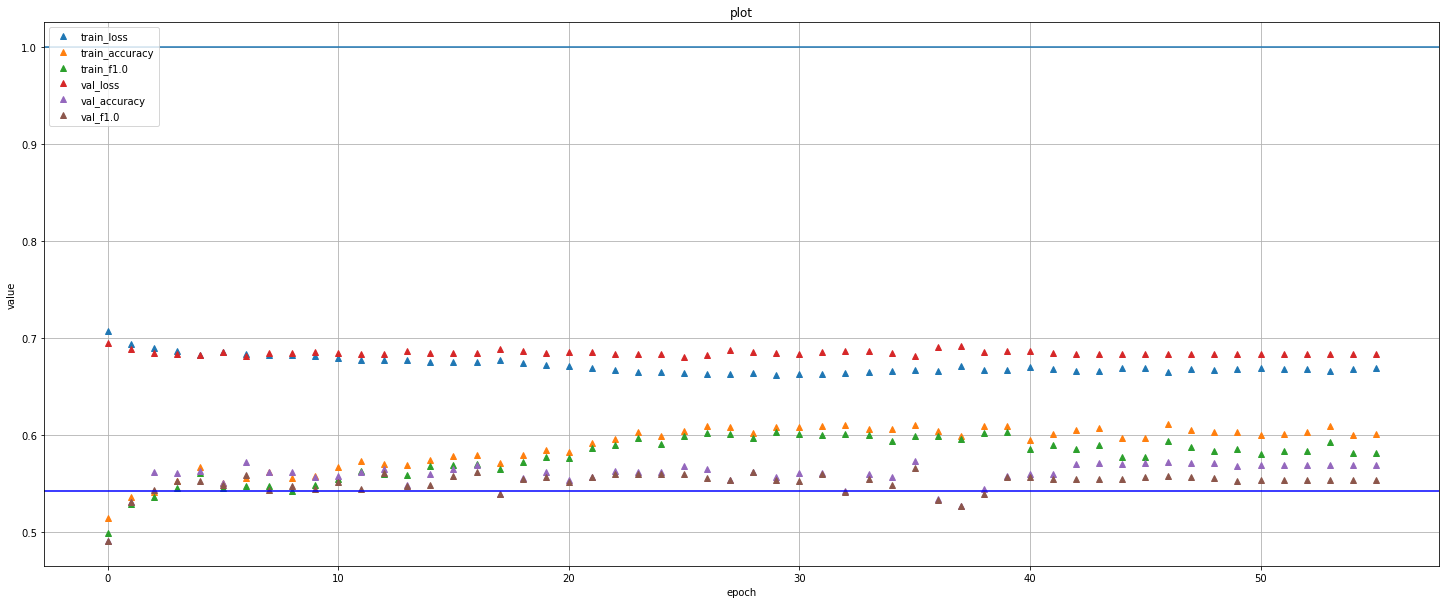

In [28]:
split1 = 'train'
split2 = 'val'
plot_df(raw_res[[f'{split1}_loss', f'{split1}_accuracy', f'{split1}_f1.0', #f'{split1}_precision', f'{split1}_recall',
                 f'{split2}_loss', f'{split2}_accuracy', f'{split2}_f1.0', #f'{split2}_precision', f'{split2}_recall'
                ]], xlabel='epoch', ylabel='value')
plt.axhline(y=max(freq_count), linestyle='-',  color='b')
plt.axhline(y=1)
plt.grid()
plt.show()

In [29]:
monitor_ser = load_df('metrics.csv', trial_dir, data_format='csv')[monitor].dropna()
monitor_ser[-len(monitor_ser)//10:].mean()

0.5535358786582947

In [30]:
raw_res[[f'{split2}_accuracy', f'{split2}_f1.0',
         f'{split2}_precision', f'{split2}_recall',
         f'{split2}_loss'
        ]].dropna().iloc[-statlen:].mean()

val_accuracy     0.569360
val_f1.0         0.553536
val_precision    0.562676
val_recall       0.557641
val_loss         0.684028
dtype: float64

In [31]:
raw_res[[f'{split1}_accuracy', f'{split1}_f1.0',
         f'{split1}_precision', f'{split1}_recall',
         f'{split1}_loss'
        ]].dropna().iloc[-statlen:].mean()

train_accuracy     0.603633
train_f1.0         0.584991
train_precision    0.626289
train_recall       0.603633
train_loss         0.667691
dtype: float64

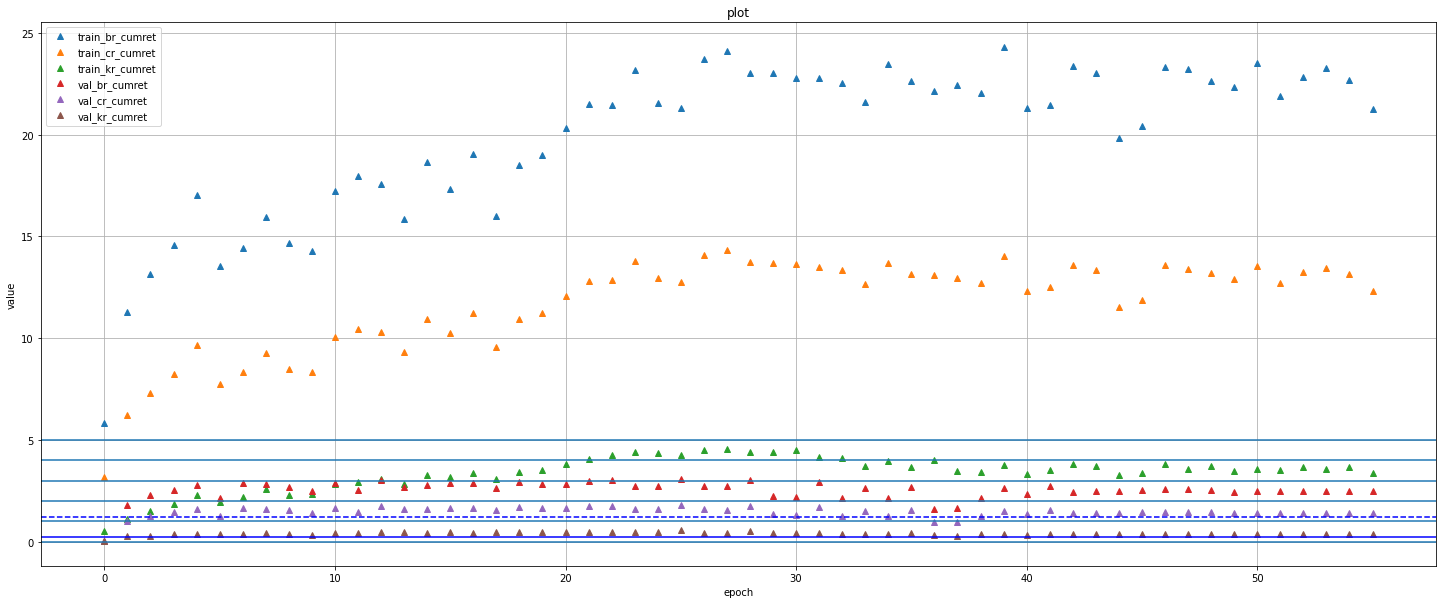

In [32]:
retmet = 'cumret' # cumret, sharpe, min, max
split = split1
plot_stats1 = [f'{split}_br_{retmet}', f'{split}_cr_{retmet}', f'{split}_kr_{retmet}',
#         f'{split}_cr_t(0.050)_{retmet}', f'{split}_cr_t(0.125)_{retmet}', f'{split}_cr_t(0.250)_{retmet}',
#         f'{split}_cr_t(0.500)_{retmet}', f'{split}_cr_t(0.750)_{retmet}',
#         f'{split}_kr_t(0.050)_{retmet}', f'{split}_kr_t(0.125)_{retmet}', f'{split}_kr_t(0.250)_{retmet}',
#         f'{split}_kr_t(0.500)_{retmet}', f'{split}_kr_t(0.750)_{retmet}',
]
split = split2
plot_stats2 = [f'{split}_br_{retmet}', f'{split}_cr_{retmet}', f'{split}_kr_{retmet}',
#         f'{split}_cr_t(0.050)_{retmet}', f'{split}_cr_t(0.125)_{retmet}', f'{split}_cr_t(0.250)_{retmet}',
#         f'{split}_cr_t(0.500)_{retmet}', f'{split}_cr_t(0.750)_{retmet}',
#         f'{split}_kr_t(0.050)_{retmet}', f'{split}_kr_t(0.125)_{retmet}', f'{split}_kr_t(0.250)_{retmet}',
#         f'{split}_kr_t(0.500)_{retmet}', f'{split}_kr_t(0.750)_{retmet}',
]
plot_df(raw_res[[*plot_stats1, *plot_stats2]], xlabel='epoch', ylabel='value')
plt.axhline(y=bench_res[f'{split1}_bs_{retmet}'], linestyle='--', color='b')
# plt.axhline(y=bench_res[f'{split1}_os_{retmet}'], linestyle='--', color='c')
plt.axhline(y=bench_res[f'{split2}_bs_{retmet}'], linestyle='-',  color='b')
# plt.axhline(y=bench_res[f'{split2}_os_{retmet}'], linestyle='-',  color='c')
plt.axhline(y=0)
plt.axhline(y=1)
plt.axhline(y=2)
plt.axhline(y=3)
plt.axhline(y=4)
plt.axhline(y=5)
plt.grid()
plt.show()

In [33]:
raw_res[plot_stats2].dropna().iloc[-statlen:].mean()

val_br_cumret    2.492527
val_cr_cumret    1.425856
val_kr_cumret    0.359184
dtype: float64

In [34]:
raw_res[plot_stats1].dropna().iloc[-statlen:].mean()

train_br_cumret    22.513225
train_cr_cumret    13.046903
train_kr_cumret     3.580580
dtype: float64

In [35]:
# from data.data_api import DataAPI
# DataAPI.__init__()

In [36]:
# recs = []
# dfs = []
# for path, rc, df in DataAPI.axe_yield(['hdzn', 'hdzn'], flt=None, lazy=False):
#     recs.append(rc)
#     dfs.append(df)

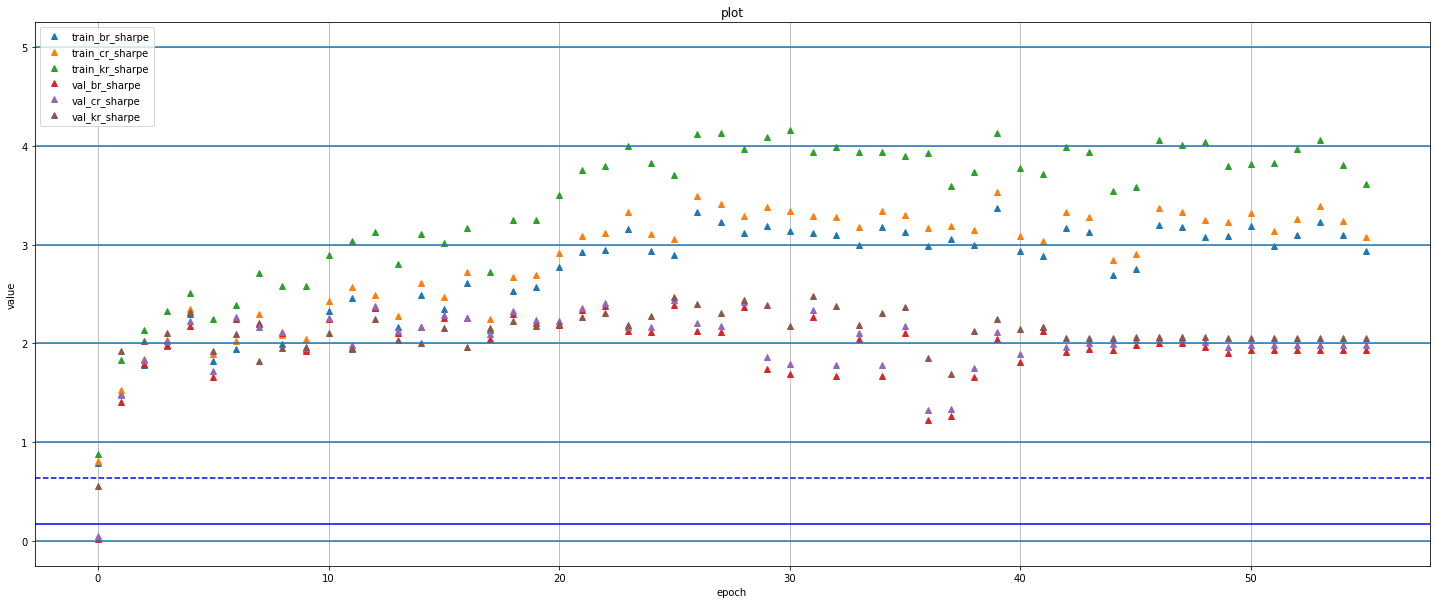

In [37]:
split1 = 'train'
split2 = 'val'
retmet = 'sharpe'
split = split1
plot_stats1 = [f'{split}_br_{retmet}', f'{split}_cr_{retmet}', f'{split}_kr_{retmet}',
#         f'{split}_cr_t(0.050)_{retmet}', f'{split}_cr_t(0.125)_{retmet}', f'{split}_cr_t(0.250)_{retmet}',
#         f'{split}_cr_t(0.500)_{retmet}', f'{split}_cr_t(0.750)_{retmet}',
#         f'{split}_kr_t(0.050)_{retmet}', f'{split}_kr_t(0.125)_{retmet}', f'{split}_kr_t(0.250)_{retmet}',
#         f'{split}_kr_t(0.500)_{retmet}', f'{split}_kr_t(0.750)_{retmet}',
]
split = split2
plot_stats2 = [f'{split}_br_{retmet}', f'{split}_cr_{retmet}', f'{split}_kr_{retmet}',
#         f'{split}_cr_t(0.050)_{retmet}', f'{split}_cr_t(0.125)_{retmet}', f'{split}_cr_t(0.250)_{retmet}',
#         f'{split}_cr_t(0.500)_{retmet}', f'{split}_cr_t(0.750)_{retmet}',
#         f'{split}_kr_t(0.050)_{retmet}', f'{split}_kr_t(0.125)_{retmet}', f'{split}_kr_t(0.250)_{retmet}',
#         f'{split}_kr_t(0.500)_{retmet}', f'{split}_kr_t(0.750)_{retmet}',
]
plot_df(raw_res[[*plot_stats1, *plot_stats2]], xlabel='epoch', ylabel='value')
plt.axhline(y=bench_res[f'{split1}_bs_{retmet}'], linestyle='--', color='b')
# plt.axhline(y=bench_res[f'{split1}_os_{retmet}'], linestyle='--', color='c')
plt.axhline(y=bench_res[f'{split2}_bs_{retmet}'], linestyle='-',  color='b')
# plt.axhline(y=bench_res[f'{split2}_os_{retmet}'], linestyle='-',  color='c')
plt.axhline(y=0)
plt.axhline(y=1)
plt.axhline(y=2)
plt.axhline(y=3)
plt.axhline(y=4)
plt.axhline(y=5)
plt.grid()
plt.show()

In [38]:
bench_res[f'{split2}_bs_{retmet}']

0.17781715095043182

In [39]:
raw_res[plot_stats2].dropna().iloc[-statlen:].mean()

val_br_sharpe    1.932979
val_cr_sharpe    1.988455
val_kr_sharpe    2.058327
dtype: float64

### Benchmark comaprison

In [40]:
raw_res[plot_stats2].dropna().iloc[-statlen:].mean() - bench_res[f'{split2}_bs_{retmet}']

val_br_sharpe    1.755162
val_cr_sharpe    1.810638
val_kr_sharpe    1.880510
dtype: float64

In [41]:
raw_res[plot_stats1].dropna().iloc[-statlen:].mean() - bench_res[f'{split1}_bs_{retmet}']

train_br_sharpe    2.450908
train_cr_sharpe    2.602341
train_kr_sharpe    3.219955
dtype: float64